In [1]:
import netCDF4
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
import trimesh

import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS


import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from DDV import eigenbasis, kernel

plt.rcParams['font.sans-serif'] = ['Outfit'] + plt.rcParams['font.sans-serif']

In [2]:
data = netCDF4.Dataset('../data/UK_daily_mean_wind.nc', 'r')
extent = [np.min(data.variables['longitude'][:].data), np.max(data.variables['longitude'][:].data), np.min(data.variables['latitude'][:].data), np.max(data.variables['latitude'][:].data)]

In [12]:
subsamp_step = 3

lons = data.variables['longitude'][:].data
lats = data.variables['latitude'][:].data

lons_sub = lons[::subsamp_step]
lats_sub = lats[::subsamp_step]

grid = np.meshgrid(lons_sub, lats_sub)

grid_points = (np.column_stack([grid[0].ravel(), grid[1].ravel()]))
n_points = len(lons_sub)*len(lats_sub)

triangulation = Delaunay(grid_points)

eigenvalues, d_vert_vecs, c_vert_vecs, vol, complex = eigenbasis.generate_vector_basis(triangulation.points, triangulation.simplices, flat=True, depth=n_points-2)
# 

Processing eigenvectors:   0%|          | 0/219 [00:00<?, ?it/s]

  0%|          | 0/219 [00:00<?, ?it/s]

In [13]:
scalar_L = complex[0].d.T @ complex[1].star @ complex[0].d
_, basis_eigenvectors = jnp.linalg.eigh(scalar_L.todense())

In [14]:
h1 = np.full((n_points, 2), np.array([1, 1]))
h2 = np.full((n_points, 2), np.array([1, -1]))
h_eigenfields = np.stack((h1, h2), axis=1).transpose(0, 2, 1)

In [15]:
params = {
    "s_d": 1,
    "s_c": 1,
    "s_h": 1,
    "v": 1.5
}

In [16]:

u = data["u10"][:, ::subsamp_step, ::subsamp_step]  # shape: (N, M, K)
v = data["v10"][:, ::subsamp_step, ::subsamp_step]  # shape: (N, M, K)

# Convert to numpy arrays
u_np = u.reshape(u.shape[0], -1)  # shape: (N, M*K)
v_np = v.reshape(v.shape[0], -1)  # shape: (N, M*K)

# Concatenate along the last axis
vec_samples = np.concatenate([u_np, v_np], axis=1).filled()  # shape: (N, M*K*2)

vec_samples_norm = np.mean(np.linalg.norm(vec_samples, axis=1))

vec_samples /= vec_samples_norm

print("uv_combined shape:", vec_samples.shape)

uv_combined shape: (2300, 442)


In [17]:
import jax.debug
jax.config.update("jax_enable_x64", True)

M = 20
phi_basis = basis_eigenvectors[:, :M]

n_points = int(vec_samples.shape[1]/2)

def nonstationary_model(Y):
    """
    Bayesian model for anisotropic kernel inference.
    
    Args:
        Y: Data array of shape (n_realizations, n_points * 2)
    """

    weights_d = numpyro.sample("weights_d", dist.Normal(0.0, 1.0).expand([M]))
    weights_c = numpyro.sample("weights_c", dist.Normal(0.0, 1.0).expand([M]))

    kappa_d = jax.nn.softplus(jnp.dot(phi_basis, weights_d)) + 2.0
    kappa_c = jax.nn.softplus(jnp.dot(phi_basis, weights_c)) + 2.0

    # Construct kernel from current parameters
    cov_kernel = kernel.vector_mesh_kernel_ns(jnp.array(eigenvalues[1:]), d_vert_vecs[:, :, 1:], c_vert_vecs[:, :, 1:], range(n_points), range(n_points), 2, vol, kappa_d, kappa_c, params, h_eigenfields) + 1e-3 * jnp.eye(n_points * 2)


    #### debug stuff
    # jax.debug.print("Symmetry error: {}", jnp.max(jnp.abs(kernel - kernel.T)))
    # 
    # eigvals = jnp.linalg.eigvalsh(kernel)
    # jax.debug.print("Smallest eigenvalue: {}", eigvals.min())
    # 
    # jax.debug.print("Any NaNs? {}", jnp.isnan(kernel).any())
    # jax.debug.print("Any Infs? {}", jnp.isinf(kernel).any())
    # 
    # svd = jnp.linalg.svd(kernel, compute_uv=False)
    # jax.debug.print("Condition number: {}", svd[0] / svd[-1])


    # Data likelihood for each realization
    with numpyro.plate("realizations", Y.shape[0]):
        numpyro.sample(
            "obs",
            dist.MultivariateNormal(
                loc=np.zeros(n_points * 2),
                covariance_matrix=cov_kernel,
                validate_args=True
            ),
            obs=Y
        )

In [18]:
from numpyro.handlers import seed, trace

tr = trace(seed(nonstationary_model, jax.random.PRNGKey(0))).get_trace(Y=vec_samples)
for name, site in tr.items():
    print(f"{name}: {site['value'].shape}")
    

weights_d: (20,)
weights_c: (20,)
realizations: (2300,)
obs: (2300, 442)


In [19]:
nuts_kernel = NUTS(nonstationary_model,
                   max_tree_depth=8,
                   adapt_step_size=True,
                   adapt_mass_matrix=True)

# Run MCMC
mcmc = MCMC(nuts_kernel,
            num_warmup=200,
            num_samples=1000)

mcmc.run(jax.random.PRNGKey(0), Y=vec_samples)

# Get posterior samples
summary_dict = numpyro.diagnostics.summary(mcmc.get_samples(), group_by_chain=False)

# print the largest r_hat for each variable
for k, v in summary_dict.items():
    spaces = " " * max(12 - len(k), 0)
    print("[{}] {} \t max r_hat: {:.4f}".format(k, spaces, np.max(v["r_hat"])))

sample: 100%|██████████| 1200/1200 [33:43<00:00,  1.69s/it, 15 steps of size 2.39e-01. acc. prob=0.91]

[weights_c]     	 max r_hat: 1.0022
[weights_d]     	 max r_hat: 1.0068


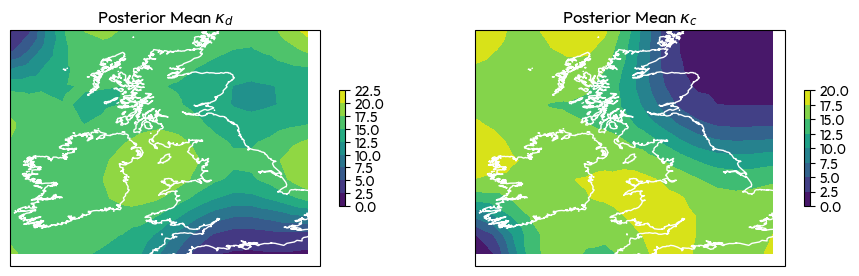

In [20]:
import scipy.interpolate
import cartopy.crs as ccrs  
import cartopy.feature as cf

coast = cf.GSHHSFeature(scale="i")

weights_d_post_mean = summary_dict["weights_d"]['mean']
weights_c_post_mean = summary_dict["weights_c"]['mean']

kd_post_mean = jax.nn.softplus(jnp.dot(phi_basis, weights_d_post_mean)) + 2
# kd_post_std = summary_dict["kappa_d"]['std']
kc_post_mean = jax.nn.softplus(jnp.dot(phi_basis, weights_c_post_mean)) + 2
# kc_post_std = summary_dict["kappa_c"]['std']

fig, axs = plt.subplots(1, 2, figsize=(11, 6), subplot_kw={'projection': ccrs.PlateCarree()})

xi = np.linspace(extent[0], extent[1], 300)
yi = np.linspace(extent[2], extent[3], 300)
xi, yi = np.meshgrid(xi, yi)

z_kd = scipy.interpolate.griddata(grid_points, kd_post_mean, (xi, yi), method='linear')
z_kc = scipy.interpolate.griddata(grid_points, kc_post_mean, (xi, yi), method='linear')

cf1 = axs[0].contourf(xi, yi, z_kd)
axs[0].title.set_text("Posterior Mean $\kappa_d$")
plt.colorbar(cf1, ax=axs[0], shrink=0.25)


cf2 = axs[1].contourf(xi, yi, z_kc)
axs[1].title.set_text("Posterior Mean $\kappa_c$")
plt.colorbar(cf2, ax=axs[1], shrink=0.25)


axs[0].add_feature(coast, edgecolor='white', zorder=1)
axs[1].add_feature(coast, edgecolor='white', zorder=1)
